In [62]:
from copy import deepcopy
import numpy as np
import pandas as pd
from scipy.cluster import hierarchy as sch
from matplotlib import pyplot as plt
import scanpy as sc
import squidpy as sq
import os
%matplotlib inline
# set work directory
#change to work directory
os.chdir(WD)
# list files in directory
os.listdir(WD)

['genes.tsv.gz', 'features.tsv.gz', 'matrix.mtx.gz', 'barcodes.tsv.gz']

In [57]:
results_file = 'dm_scanpy.h5ad'
###################### Not Working ############################
adata = sc.read_10x_mtx(
    WD,  # the directory with the `.mtx` file
    var_names='gene_symbols',                      # use gene symbols for the variable names (variables-axis index)
    cache=False,
    make_unique=False,
)
# not necessary if var_names are gene_ids
adata.var_names_make_unique()
adata

/home/davy/miniconda3/envs/bio/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


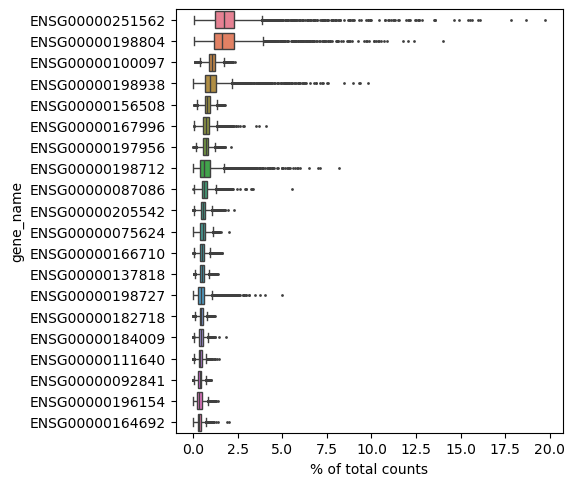

In [74]:
# show top 20 genes
sc.pl.highest_expr_genes(adata, n_top=20)

In [76]:
# filter cells and genes
sc.pp.filter_cells(adata, min_genes=200)
adata


AnnData object with n_obs × n_vars = 13525 × 37493
    obs: 'cell_id', 'n_genes'
    var: 'gene_name'

In [77]:

sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 13525 × 21043
    obs: 'cell_id', 'n_genes'
    var: 'gene_name', 'n_cells'

In [83]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
adata

AnnData object with n_obs × n_vars = 13525 × 21043
    obs: 'cell_id', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_name', 'n_cells'

/home/davy/miniconda3/envs/bio/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


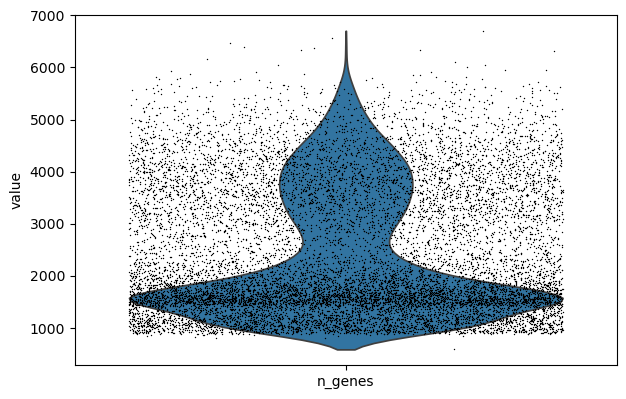

In [95]:
sc.pl.violin(adata, keys=['n_genes', ],
             jitter=0.4, )

/home/davy/miniconda3/envs/bio/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


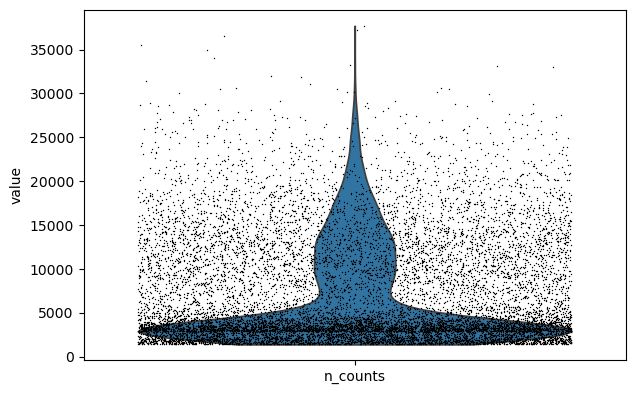

In [96]:
sc.pl.violin(adata, keys=['n_counts', ],
             jitter=0.4, )

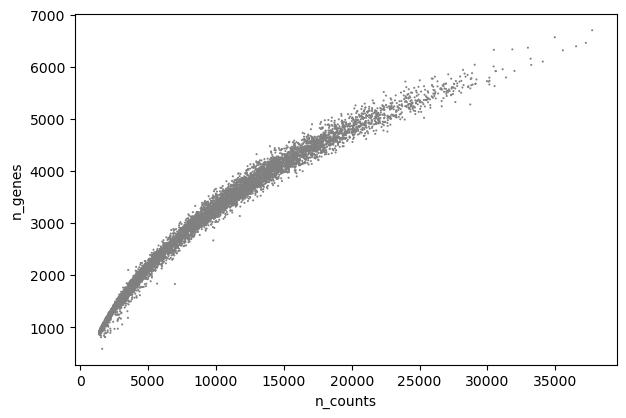

In [97]:
sc.pl.scatter(adata, x='n_counts', y='n_genes')

## Normalization
The next preprocessing step is normalization. A common approach is count depth scaling with subsequent log plus one (log1p) transformation. Count depth scaling normalizes the data to a “size factor” such as the median count depth in the dataset, ten thousand (CP10k) or one million (CPM, counts per million). The size factor for count depth scaling can be controlled via target_sum in pp.normalize_total. We are applying median count depth normalization with log1p transformation (AKA log1PF).

In [98]:
# Saving count data
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
#sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)
adata.raw = adata
adata

AnnData object with n_obs × n_vars = 13525 × 21043
    obs: 'cell_id', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_name', 'n_cells'
    uns: 'log1p'
    layers: 'counts'

### Feature selection
As a next step, we want to reduce the dimensionality of the dataset and only include the most informative genes. This step is commonly known as feature selection. The scanpy function pp.highly_variable_genes annotates highly variable genes by reproducing the implementations of Seurat [Satija et al., 2015], Cell Ranger [Zheng et al., 2017], and Seurat v3 [Stuart et al., 2019] depending on the chosen flavor

In [100]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

/home/davy/miniconda3/envs/bio/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


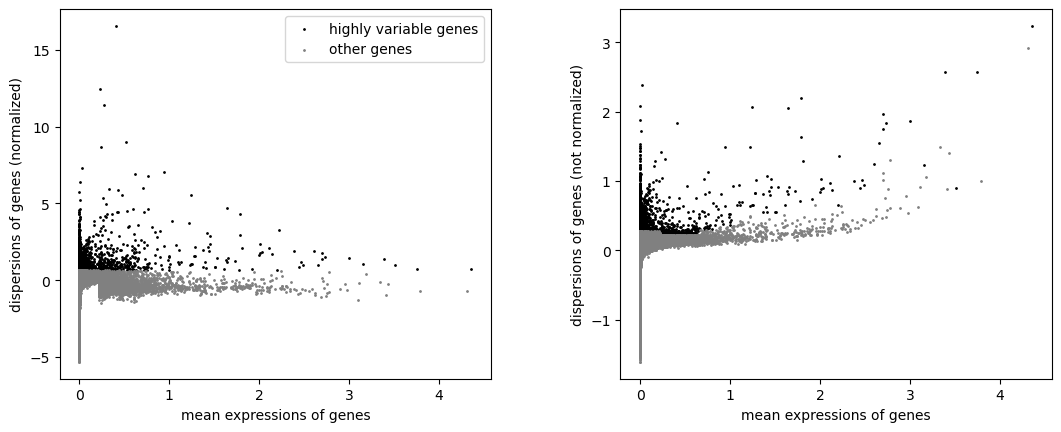

In [101]:
sc.pl.highly_variable_genes(adata)

In [102]:

adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 13525 × 3000
    obs: 'cell_id', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

### Dimensionality Reduction
Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [103]:
sc.tl.pca(adata)

/home/davy/miniconda3/envs/bio/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function leiden() or tsne(). In our experience, there does not seem to be signifigant downside to overestimating the numer of principal components.

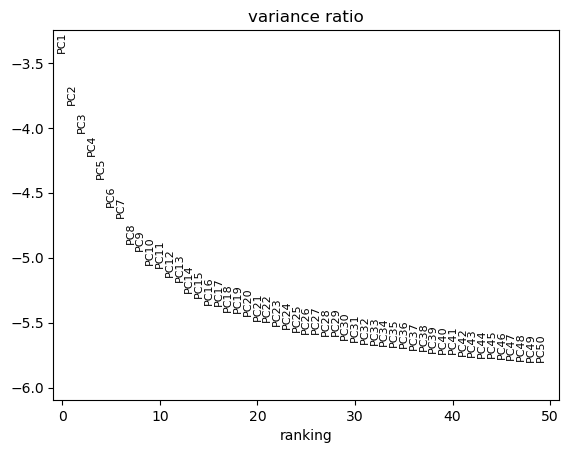

In [104]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

You can also plot the principal components to see if there are any potentially undesired features (e.g. batch, QC metrics) driving signifigant variation in this dataset. In this case, there isn’t anything too alarming, but it’s a good idea to explore this.

In [107]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')


adata


AnnData object with n_obs × n_vars = 13525 × 3000
    obs: 'cell_id', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [ ]:

adata.obsm['X_pca']
adata.varm['PCs']

/home/davy/miniconda3/envs/bio/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


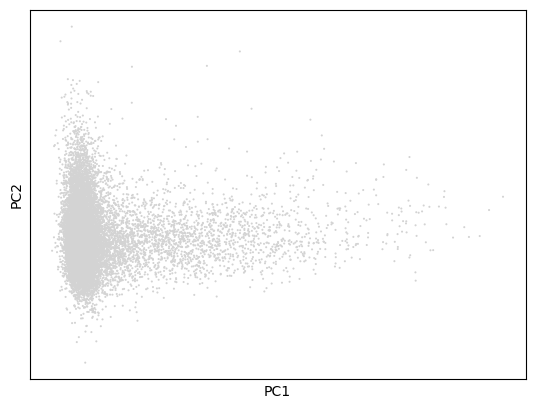

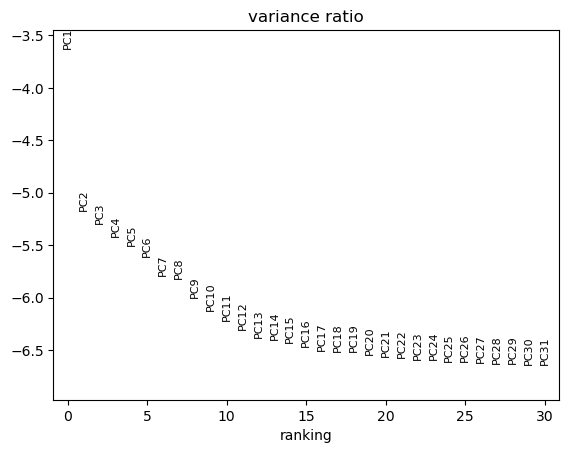

In [111]:
sc.pl.pca(adata)
sc.pl.pca_variance_ratio(adata, log=True)

In [112]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
adata


/home/davy/miniconda3/envs/bio/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AnnData object with n_obs × n_vars = 13525 × 3000
    obs: 'cell_id', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [113]:
sc.tl.leiden(adata)

adata.obs['leiden']

0         9
1         1
2         3
3         1
4         0
         ..
13520     6
13521    10
13522     4
13523     5
13524     3
Name: leiden, Length: 13525, dtype: category
Categories (13, object): ['0', '1', '2', '3', ..., '9', '10', '11', '12']

/home/davy/miniconda3/envs/bio/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/davy/miniconda3/envs/bio/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


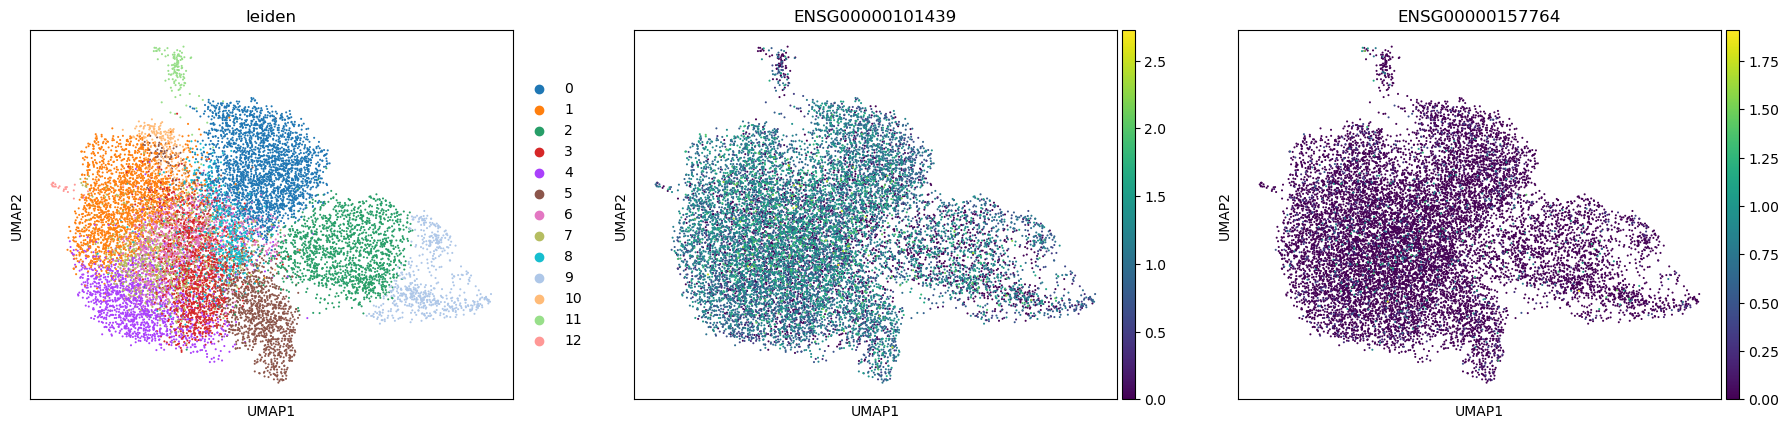

In [120]:
sc.pl.umap(adata, color=['leiden', 'ENSG00000101439', 'ENSG00000157764'])
#sc.pl.umap(adata, color=['leiden', 'CD3D', 'NKG7'])

### statistic test for differential expression ###


In [121]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

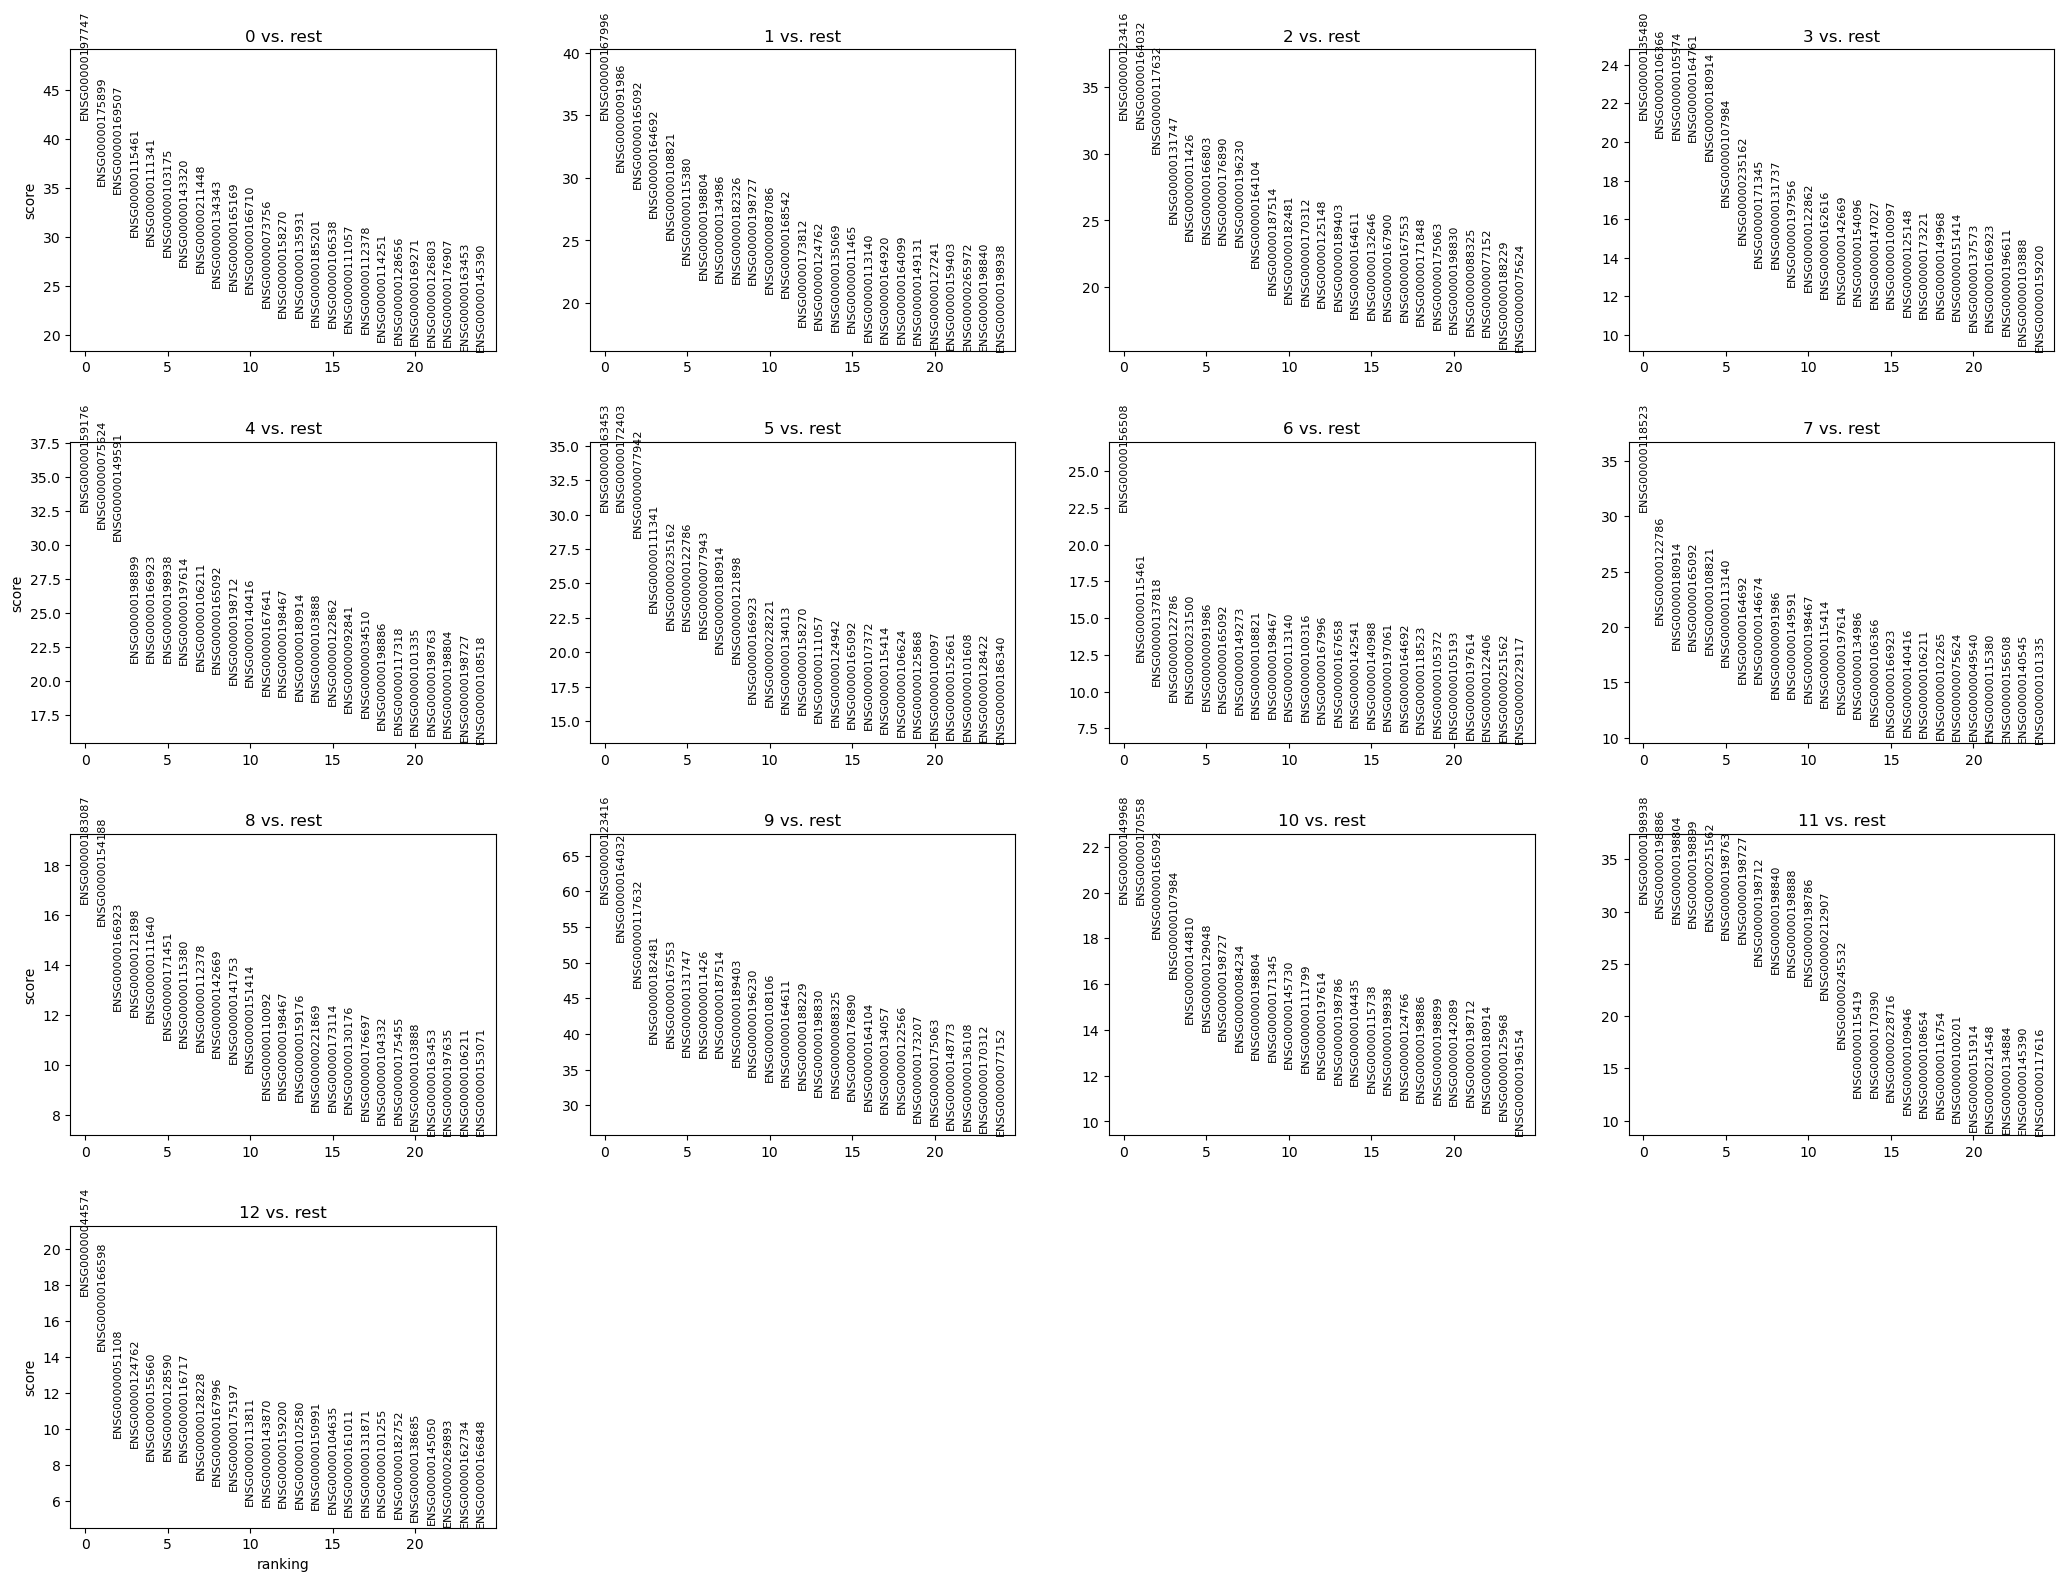

In [122]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
sc.settings.verbosity = 2  # reduce the verbosity

In [123]:
sc.get.rank_genes_groups_df(adata, group="0")

,names,scores,logfoldchanges,pvals,pvals_adj
0,ENSG00000197747,42.010193,1.073034,8.902075e-320,9.366318e-316
1,ENSG00000175899,35.236744,1.618696,8.765646e-229,3.689110e-225
2,ENSG00000169507,34.399139,0.992986,3.998675e-226,1.402402e-222
3,ENSG00000115461,29.988400,0.686539,3.064123e-178,7.164260e-175
4,ENSG00000111341,29.139885,1.035663,4.149647e-168,8.732103e-165
...,...,...,...,...,...
21038,ENSG00000159176,-30.719429,-1.056563,1.261456e-186,3.318103e-183
21039,ENSG00000166923,-32.156326,-1.020471,8.035983e-202,2.415731e-198
21040,ENSG00000180914,-35.215950,-1.018337,1.156776e-235,6.085509e-232
21041,ENSG00000197614,-37.365223,-1.685063,1.006428e-271,7.059423e-268


ranking genes


/home/davy/miniconda3/envs/bio/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


    finished (0:00:13)


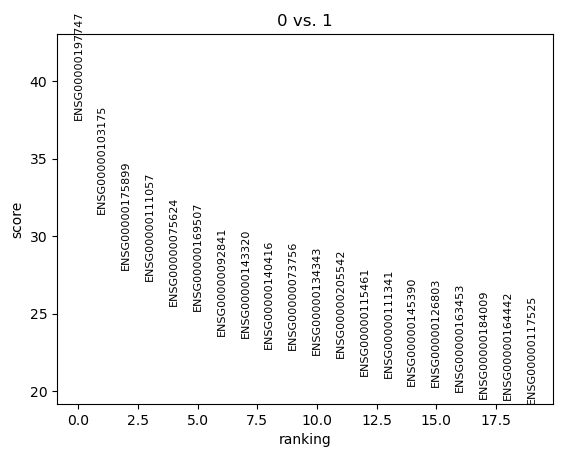

In [124]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

In [ ]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

In [128]:
adata.obs['cell_id'] = adata.obs['cell_id'].astype(str)
adata.write(results_file, compression='gzip')

In [127]:
adata.X = None
adata.obs[['n_counts', 'leiden']].to_csv(
     'DM_corrected_lei_groups.csv')